In [1]:
import os
import pickle
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
from data import Dataset, LMOrderedIterator


2023-11-03 22:36:21.013367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 22:36:21.565543: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2023-11-03 22:36:21.565585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2023-11-03 22:36:21.565591: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
class Transformer_xl_config:
    def __init__(self, data='/home/jun/workspace/wiki_short/', dataset='wt103', n_layer=12, n_head=10,
                 d_head=50, d_embed=-1, d_model=500, d_inner=1000, dropout=0.0, dropatt=0.0,
                 init='normal', emb_init='normal', init_range=0.1, emb_init_range=0.01,
                 init_std=0.02, proj_init_std=0.01, optim='adam', lr=0.00025, mom=0.0,
                 scheduler='cosine', warmup_step=0, decay_rate=0.5, lr_min=0.0, clip=0.25,
                 clip_nonemb=False, max_step=100000, batch_size=60, batch_chunk=1,
                 tgt_len=70, eval_tgt_len=50, ext_len=0, mem_len=0, not_tied=False,
                 seed=1111, cuda=False, adaptive=False, div_val=1, pre_lnorm=False,
                 varlen=False, multi_gpu=False, log_interval=200, eval_interval=4000,
                 work_dir='LM-TFM', restart=False, restart_dir='', debug=False,
                 same_length=False, attn_type=0, clamp_len=-1, eta_min=0.0, gpu0_bsz=-1,
                 max_eval_steps=-1, sample_softmax=-1, patience=0, finetune_v2=False,
                 finetune_v3=False, fp16=False, static_loss_scale=1, dynamic_loss_scale=False,n_token=None):
        
        self.data = data
        self.dataset = dataset
        self.n_layer = n_layer
        self.n_head = n_head
        self.d_head = d_head
        self.d_embed = d_embed
        self.d_model = d_model
        self.d_inner = d_inner
        self.dropout = dropout
        self.dropatt = dropatt
        self.init = init
        self.emb_init = emb_init
        self.init_range = init_range
        self.emb_init_range = emb_init_range
        self.init_std = init_std
        self.proj_init_std = proj_init_std
        self.optim = optim
        self.lr = lr
        self.mom = mom
        self.scheduler = scheduler
        self.warmup_step = warmup_step
        self.decay_rate = decay_rate
        self.lr_min = lr_min
        self.clip = clip
        self.clip_nonemb = clip_nonemb
        self.max_step = max_step
        self.batch_size = batch_size
        self.batch_chunk = batch_chunk
        self.tgt_len = tgt_len
        self.eval_tgt_len = eval_tgt_len
        self.ext_len = ext_len
        self.mem_len = mem_len
        self.not_tied = not_tied
        self.seed = seed
        self.cuda = cuda
        self.adaptive = adaptive
        self.div_val = div_val
        self.pre_lnorm = pre_lnorm
        self.varlen = varlen
        self.multi_gpu = multi_gpu
        self.log_interval = log_interval
        self.eval_interval = eval_interval
        self.work_dir = work_dir
        self.restart = restart
        self.restart_dir = restart_dir
        self.debug = debug
        self.same_length = same_length
        self.attn_type = attn_type
        self.clamp_len = clamp_len
        self.eta_min = eta_min
        self.gpu0_bsz = gpu0_bsz
        self.max_eval_steps = max_eval_steps
        self.sample_softmax = sample_softmax
        self.patience = patience
        self.finetune_v2 = finetune_v2
        self.finetune_v3 = finetune_v3
        self.fp16 = fp16
        self.static_loss_scale = static_loss_scale
        self.dynamic_loss_scale = dynamic_loss_scale
        self.n_token = n_token
config = Transformer_xl_config()

In [3]:
import os
from collections import Counter, OrderedDict


class Vocab(object):
    def __init__(self, special=[], min_freq=0, max_size=None, lower_case=True,
                 delimiter=None, vocab_file=None):
        self.counter = Counter()
        self.special = special
        self.min_freq = min_freq
        self.max_size = max_size
        self.lower_case = lower_case
        self.delimiter = delimiter
        self.vocab_file = vocab_file

    def tokenize(self, line, add_eos=False, add_double_eos=False):
        line = line.strip() # 문자열 앞 뒤 공백제거
        # convert to lower case
        if self.lower_case:
            line = line.lower()

        # empty delimiter '' will evaluate False #구분자에 따라 문장을 분할 line = "This is an example sentence."
        #symbols = ['This', 'is', 'an', 'example', 'sentence.']

        if self.delimiter == '':
            symbols = line
        else:
            symbols = line.split(self.delimiter)

        if add_double_eos: # lm1b
            return ['<S>'] + symbols + ['<S>']
        elif add_eos:
            return symbols + ['<eos>']  #symbols = ['This', 'is', 'an', 'example', 'sentence.', '<eos>']

        else:
            return symbols

    def count_file(self, path, verbose=False, add_eos=False):
        if verbose: print('counting file {} ...'.format(path))
        assert os.path.exists(path)

        sents = []
        with open(path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos)
                self.counter.update(symbols)
                sents.append(symbols)

        return sents

    def count_sents(self, sents, verbose=False):
        """
            sents : a list of sentences, each a list of tokenized symbols
        """
        if verbose: print('counting {} sents ...'.format(len(sents)))
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            self.counter.update(symbols)

    def _build_from_file(self, vocab_file):
        self.idx2sym = []
        self.sym2idx = OrderedDict()

        with open(vocab_file, 'r', encoding='utf-8') as f:
            for line in f:
                symb = line.strip().split()[0]
                self.add_symbol(symb)
        self.unk_idx = self.sym2idx['<UNK>']


       
    def build_vocab(self):  # 이 함수를 호출함으로써 문장 목록에 있는 단어들에 대하여 매칭 되는 숫자가 생기고 그 값이  self.sym2idx = OrderedDict() 에 들어가는 것
        if self.vocab_file:
            print('building vocab from {}'.format(self.vocab_file))
            self._build_from_file(self.vocab_file)
            print('final vocab size {}'.format(len(self)))
        else:
            print('building vocab with min_freq={}, max_size={}'.format(
                self.min_freq, self.max_size))
            self.idx2sym = []
            self.sym2idx = OrderedDict()

            for sym in self.special:
                self.add_special(sym)

            for sym, cnt in self.counter.most_common(self.max_size): # 빈도가 가장 높은 max size까지의(ex:5000)단어를 가져옴 sym 단어, cnt 카운트
                if cnt < self.min_freq: break
                self.add_symbol(sym)  

            print('final vocab size {} from {} unique tokens'.format(
                len(self), len(self.counter)))   

    def encode_file(self, path, ordered=False, verbose=False, add_eos=True,
            add_double_eos=False):
        if verbose: print('encoding file {} ...'.format(path))
        assert os.path.exists(path)
        encoded = []
        with open(path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos,
                    add_double_eos=add_double_eos)
                encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            encoded = tf.concat(encoded, axis=0)

        return encoded

    def encode_sents(self, sents, ordered=False, verbose=False):
        if verbose: print('encoding {} sents ...'.format(len(sents)))
        encoded = []
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            encoded = tf.concat(encoded,axis=0)

        return encoded

    def add_special(self, sym):
        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1
            setattr(self, '{}_idx'.format(sym.strip('<>')), self.sym2idx[sym])

    def add_symbol(self, sym):
        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1
    '''{           이렇게 sym2idx 에 단어랑 매칭 되는 숫자가 생긴다. 
    "apple": 0,
    "banana": 1,
    "cherry": 2
    }
    '''

    def get_sym(self, idx):
        assert 0 <= idx < len(self), 'Index {} out of range'.format(idx)
        return self.idx2sym[idx]

    def get_idx(self, sym):
        if sym in self.sym2idx:
            # print(self.sym2idx[sym])
            return self.sym2idx[sym] # build voca를 통해 생긴 딕셔너리에서 단어 sym에 일치하는 숫자값을 리턴
        else:
            # print('encounter unk {}'.format(sym))
            assert '<eos>' not in sym
            # assert hasattr(self, 'unk_idx')
            self.idx2sym.append('UNK')
            self.sym2idx[sym] = len(self.idx2sym) - 1
            self.unk_idx = self.sym2idx['<UNK>']

            return self.sym2idx.get(sym, self.unk_idx)

    def get_symbols(self, indices):
        return [self.get_sym(idx) for idx in indices]

    def get_indices(self, symbols):
        return [self.get_idx(sym) for sym in symbols]

    def convert_to_tensor(self, symbols):
        return tf.convert_to_tensor(self.get_indices(symbols), dtype=tf.int32)

    def convert_to_sent(self, indices, exclude=None):
        if exclude is None:
            return ' '.join([self.get_sym(idx) for idx in indices])
        else:
            return ' '.join([self.get_sym(idx) for idx in indices if idx not in exclude])

    def __len__(self):
        return len(self.idx2sym)

In [4]:
class LMOrderedIterator(object):
    def __init__(self, data, bsz, bptt, device='cpu', ext_len=None):
        """
            data -- LongTensor -- the LongTensor is strictly ordered
        """
        self.bsz = 18 #60
        self.bptt = 36 #70
        self.ext_len = ext_len if ext_len is not None else 0

        self.device = device
        self.data = data

        
        # Work out how cleanly we can divide the dataset into bsz parts.
        # 아래의 두 코드는   data 텐서에서 배치 크기 bsz로 깔끔하게 맞지 않는 추가 요소를 제거하는 것 배치에 띡 떨어지게
        self.n_step = self.data.shape[0] // self.bsz
        print(self.n_step)

        # Trim off any extra elements that wouldn't cleanly fit (remainders).
        sliced_data = tf.slice(self.data,[0],[self.n_step * self.bsz])  
        print('sliced_data',sliced_data)
        '''# 시작 위치와 슬라이싱할 크기 설정
        begin = [0]  # 첫 번째 차원의 시작 위치는 0
        size = [6]   # 첫 번째 차원에서 6개의 원소를 슬라이싱

        # 데이터를 잘라내기 (tf.slice 사용)
        sliced_data = tf.slice(data, begin, size)  '''

        # Evenly divide the data across the bsz batches.
        new_shape = (self.bsz, -1)  # 나머지 차원은 자동으로 계산됨
        data_reshaped = tf.reshape(sliced_data, new_shape)
        data_transposed = tf.transpose(data_reshaped)
        '''
        로,또,1,등,당,첨 = > 로,또,1    => 로, 등
                        등,당,첨         또, 당
                                        1, 첨
        '''
        '''
        TensorFlow 2.x에서는 tf.device()를 사용하여 장치를 지정하는 방법이 아닙니다. 대신 tf.device()로 장치 컨텍스트를 설정한 후, 해당 컨텍스트 내에서 작업을 수행해야 합니다.
        '''    
        with tf.device(device):
            self.data = data_transposed
        
        # self.data = data.view(bsz, -1).t().contiguous().to(device)

        # Number of mini-batches
        self.n_batch = (self.n_step + self.bptt - 1) // self.bptt

    def get_batch(self, i, bptt=None):
        if bptt is None: bptt = self.bptt
        seq_len = min(bptt, self.data.shape[0] - 1 - i) # # i값이 103227020를 넘지 않는 이상 seq_len = 70


        end_idx = i + seq_len # 70,71,72,73,74......
        beg_idx = max(0, i - self.ext_len) # 0,1,2,3,4,5
        ''' 아래 처럼 첫번째 차원을 자르는 이류
        로,또,1,등,당,첨 = > 로,또,1    => 로, 등
                        등,당,첨         또, 당
                                        1, 첨
        '''
        data = self.data[beg_idx:end_idx] # self.data[0:70],[1:71] ~
        target = self.data[i+1:i+1+seq_len] #self.data[1:71],[2:72] ~

        return data, target, seq_len

    def get_fixlen_iter(self, start=0):
        for i in range(start, self.data.shape[0] - 1, self.bptt):
            yield self.get_batch(i) # 제너레이터 yield를  통해 만듬

    def get_varlen_iter(self, start=0, std=5, min_len=5, max_deviation=3):
        max_len = self.bptt + max_deviation * std
        i = start
        while True:
            bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
            bptt = min(max_len, max(min_len, int(np.random.normal(bptt, std))))
            data, target, seq_len = self.get_batch(i, bptt)
            i += seq_len
            yield data, target, seq_len
            if i >= self.data.size(0) - 2:
                break

    def __iter__(self):
        return self.get_fixlen_iter() # tr_iter 등의 변수로 저장되며 변수는 호출 될 때마다 값을 하나씩 벹음
    

In [5]:
# class LMShuffledIterator(object):
#     def __init__(self, data, bsz, bptt, device='cpu', ext_len=None, shuffle=False):
#         """
#             data -- list[LongTensor] -- there is no order among the LongTensors
#         """
#         self.data = data
#         print(self.data)
#         self.bsz = bsz
#         self.bptt = bptt
#         self.ext_len = ext_len if ext_len is not None else 0

#         self.device = device
#         self.shuffle = shuffle

#     def get_sent_stream(self):
#         # index iterator
#         epoch_indices = np.random.permutation(len(self.data)) if self.shuffle \
#             else np.array(range(len(self.data)))

#         # sentence iterator
#         for idx in epoch_indices:
#             yield self.data[idx]

#     def stream_iterator(self, sent_stream):
#         # streams for each data in the batch
#         streams = [None] * self.bsz

#         data = tf.convert_to_tensor(self.bptt, self.bsz, dtype=tf.int32)
#         target = tf.convert_to_tensor(self.bptt, self.bsz, dtype=tf.int32)

#         n_retain = 0

#         while True:
#             # data   : [n_retain+bptt x bsz]
#             # target : [bptt x bsz]
#             data[n_retain:].fill_(-1)
#             target.fill_(-1)

#             valid_batch = True

#             for i in range(self.bsz):
#                 n_filled = 0
#                 try:
#                     while n_filled < self.bptt:
#                         if streams[i] is None or len(streams[i]) <= 1:
#                             streams[i] = next(sent_stream)
#                         # number of new tokens to fill in
#                         n_new = min(len(streams[i]) - 1, self.bptt - n_filled)
#                         # first n_retain tokens are retained from last batch
#                         data[n_retain+n_filled:n_retain+n_filled+n_new, i] = \
#                             streams[i][:n_new]
#                         target[n_filled:n_filled+n_new, i] = \
#                             streams[i][1:n_new+1]
#                         streams[i] = streams[i][n_new:]
#                         n_filled += n_new
#                 except StopIteration:
#                     valid_batch = False
#                     break

#             if not valid_batch:
#                 return

#             data = data.to(self.device)
#             target = target.to(self.device)

#             yield data, target, self.bptt

#             n_retain = min(data.size(0), self.ext_len)
#             if n_retain > 0:
#                 data[:n_retain] = data[-n_retain:]
#             data.resize_(n_retain + self.bptt, data.size(1))

#     def __iter__(self):
#         # sent_stream is an iterator
#         sent_stream = self.get_sent_stream()

#         for batch in self.stream_iterator(sent_stream):
#             yield batch


# class LMMultiFileIterator(LMShuffledIterator):
#     def __init__(self, paths, vocab, bsz, bptt, device='cpu', ext_len=None,
#         shuffle=False):

#         self.paths = paths
#         self.vocab = vocab

#         self.bsz = bsz
#         self.bptt = bptt
#         self.ext_len = ext_len if ext_len is not None else 0

#         self.device = device
#         self.shuffle = shuffle

#     def get_sent_stream(self, path):
#         sents = self.vocab.encode_file(path, add_double_eos=True)
#         if self.shuffle:
#             np.random.shuffle(sents)
#         sent_stream = iter(sents)

#         return sent_stream

#     def __iter__(self):
#         if self.shuffle:
#             np.random.shuffle(self.paths)

#         for path in self.paths:
#             # sent_stream is an iterator
#             sent_stream = self.get_sent_stream(path)
#             for batch in self.stream_iterator(sent_stream):
#                 yield batch


In [6]:
class Corpus(object):
    def __init__(self, path, dataset, *args, **kwargs):
        self.dataset = dataset
        self.vocab = Vocab(*args, **kwargs)

        if self.dataset in ['ptb', 'wt2', 'enwik8', 'text8']:
            self.vocab.count_file(os.path.join(path, 'train.txt'))
            self.vocab.count_file(os.path.join(path, 'valid.txt'))
            self.vocab.count_file(os.path.join(path, 'test.txt'))
        elif self.dataset == 'wt103':
            self.vocab.count_file(os.path.join(path, 'train.txt'))
        elif self.dataset == 'lm1b':
            train_path_pattern = os.path.join(
                path, '1-billion-word-language-modeling-benchmark-r13output',
                'training-monolingual.tokenized.shuffled', 'news.en-*')
            train_paths = glob.glob(train_path_pattern)
            # the vocab will load from file when build_vocab() is called

        self.vocab.build_vocab()

        if self.dataset in ['ptb', 'wt2', 'wt103']:
            self.train = self.vocab.encode_file(
                os.path.join(path, 'train.txt'), ordered=True)    
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=True)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=True)
        elif self.dataset in ['enwik8', 'text8']:
            self.train = self.vocab.encode_file(
                os.path.join(path, 'train.txt'), ordered=True, add_eos=False)
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=True, add_eos=False)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=True, add_eos=False)
        elif self.dataset == 'lm1b':
            self.train = train_paths
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=False, add_double_eos=True)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=False, add_double_eos=True)

    def get_iterator(self, split, *args, **kwargs):
        if split == 'train':
            if self.dataset in ['ptb', 'wt2', 'wt103', 'enwik8', 'text8']:
                data_iter = LMOrderedIterator(self.train, *args, **kwargs)
            elif self.dataset == 'lm1b':
                kwargs['shuffle'] = True
                data_iter = LMMultiFileIterator(self.train, self.vocab, *args, **kwargs)
        elif split in ['valid', 'test']:
            data = self.valid if split == 'valid' else self.test
            if self.dataset in ['ptb', 'wt2', 'wt103', 'enwik8', 'text8']:
                data_iter = LMOrderedIterator(data, *args, **kwargs)
            elif self.dataset == 'lm1b':
                data_iter = LMShuffledIterator(data, *args, **kwargs)

        return data_iter

In [7]:
def get_lm_corpus(datadir, dataset):
    fn = os.path.join(datadir, 'cache_short_cpu.pkl')
    if os.path.exists(fn):
        print('Loading cached dataset...')
        with open(fn, 'rb') as file:
            corpus = pickle.load(file)
            
    else:
        print('Producing dataset {}...'.format(dataset))
        kwargs = {}
        if dataset in ['wt103', 'wt2']:
            kwargs['special'] = ['<eos>','<UNK>']
            kwargs['lower_case'] = False
        elif dataset == 'ptb':
            kwargs['special'] = ['<eos>']
            kwargs['lower_case'] = True
        elif dataset == 'lm1b':
            kwargs['special'] = []
            kwargs['lower_case'] = False
            kwargs['vocab_file'] = os.path.join(datadir, '1b_word_vocab.txt')
        elif dataset in ['enwik8', 'text8']:
            pass

        corpus = Corpus(datadir, dataset, **kwargs)
        
        
        
        
        fn = os.path.join(datadir, "cache_short_cpu.pkl")

        with open(fn, "wb") as fp:
            pickle.dump(corpus, fp, protocol=2)
            
    return corpus


데이터셋 만들기랑 제너레이터(내 코드에서는 이터레이터)를 분리시켜서 데이서셋 상태에서는 tf 형태로 안바꿔서 cpu에 메모리 확보하고 
모델에 넣을 때 즉 이터레이터 돌릴 때만 tf 형태로 변경해서 gpu 메모리 확보하자

In [8]:
corpus = get_lm_corpus(config.data, config.dataset)


Loading cached dataset...


2023-11-02 17:55:10.000713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 17:55:10.001039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 17:55:10.005344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 17:55:10.005647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 17:55:10.005932: I tensorflow/compiler/xla/stream_executo

In [9]:
corpus.train

<tf.Tensor: shape=(5630029,), dtype=int32, numpy=array([   0,   10, 8539, ...,  442,    4,    0], dtype=int32)>

In [10]:
len(corpus.vocab)

109697

In [11]:
corpus = get_lm_corpus(config.data, config.dataset)

ntokens = len(corpus.vocab)
n_token = ntokens
config.n_token

data_len = config.tgt_len * 20 # 20이 Segment의 갯수를 나타냅니다.
device='gpu:0'

eval_batch_size = 10
tr_iter = corpus.get_iterator('train', config.batch_size, config.tgt_len,
    device=device, ext_len=config.ext_len)
va_iter = corpus.get_iterator('valid', eval_batch_size, config.eval_tgt_len,
    device=device, ext_len=config.ext_len)
te_iter = corpus.get_iterator('test', eval_batch_size, config.eval_tgt_len,
    device=device, ext_len=config.ext_len)


312779
sliced_data tf.Tensor([   0   10 8539 ...    9  223 5159], shape=(5630022,), dtype=int32)
12091
sliced_data tf.Tensor([    0    10 20770 ...    10    10    10], shape=(217638,), dtype=int32)
13642
sliced_data tf.Tensor([    0    10   699 ...   124 10979  4368], shape=(245556,), dtype=int32)


In [ ]:
# a= np.array(AA)
# b=pd.DataFrame(a)
# b

In [ ]:
from transformers import TransfoXLConfig

config_xl = TransfoXLConfig(
    d_embed=128,
    d_head = 32,
    d_model=128,
    mem_len=400,
    n_head=8,
    n_layer=6,
)

/home/jun/miniconda3/envs/new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from model import TFTransfoXLModel,TFTransfoXLLMHeadModel



# with strategy.scope():
model = TFTransfoXLLMHeadModel(config=config_xl)


In [ ]:
# outputs = model(input_ids=data,labels=target)

In [ ]:
# for i in range(2):
#     mems= None
#     for batch, (data, target, seq_len) in enumerate(tr_iter):
#         outputs1 = model(input_ids =data, labels=target,mems=mems)
#         mems = outputs1.mems

In [ ]:
# # 모델에서 나온 문장 예측하기
# prediction_scores = outputs.prediction_scores
# predicted_token = tf.argmax(prediction_scores, axis = -1) #하나의 단어에 d_model 차원의 값으로 된 값을 argmax를 통해 단어장에서 가장 높은 확률을 나타내는 단어로 반환

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = tf.cast(d_model, tf.float32)

    self.warmup_steps = tf.cast(warmup_steps,tf.float32)

  def __call__(self, step):
    step =tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:

learning_rate = CustomSchedule(config_xl.d_model)



In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

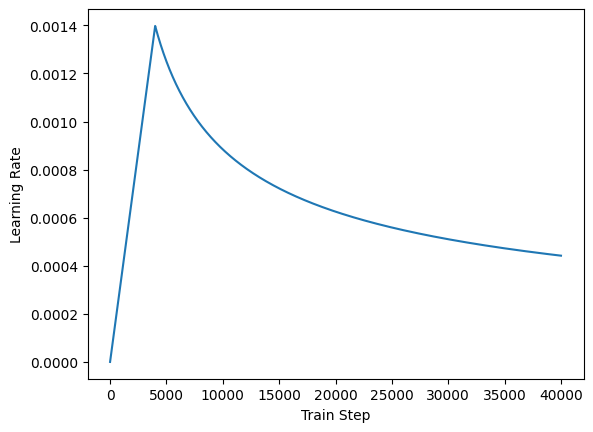

In [ ]:
temp_learning_rate_schedule = CustomSchedule(config_xl.d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [ ]:

# train_step_signature = [
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
# ]

# @tf.function(input_signature=train_step_signature)
def train_step(data, target,mems):
  

  with tf.GradientTape() as tape:
    outputs = model(input_ids=data,labels=target,mems=mems)
    loss = outputs.loss
    mems = outputs.mems

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  return mems,loss

In [ ]:
for epoch in range(6):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  mems = None
  for batch, (data, target, seq_len) in enumerate(tr_iter):
    
    mems,loss = train_step(data, target,mems)
    print('loss',loss)
    
    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

2023-11-01 16:28:03.860469: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x559d59c381d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-01 16:28:03.860488: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2023-11-01 16:28:03.860491: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2023-11-01 16:28:03.863853: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-01 16:28:03.940263: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.415924>]
Epoch 1 Batch 0 Loss 10.4159 Accuracy 0.0000
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.391776>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.517251>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.459324>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.34837>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.403845>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.41347>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.604045>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.403836>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.600828>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.575915>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.400618>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.394195>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.354757>]
loss [<tf.Tensor: shape=(), dtype=float32, numpy=10.4038105>]
loss [<tf.Tensor: shape=(), dtype=float32

KeyboardInterrupt: 

In [ ]:
# 가상의 3차원 데이터 생성 (3개의 샘플, 각 샘플은 2x2 형태의 행렬)
input_data = tf.constant([[[1.0, 2.0], [3.0, 4.0]],
                          [[5.0, 6.0], [7.0, 8.0]],
                          [[9.0, 10.0], [11.0, 12.0]]])

# 간단한 모델을 생성하고 Dense 레이어에 3차원 입력으로 바로 사용합니다.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(input_data.shape[1], input_data.shape[2])))

# 모델 요약을 출력합니다.
model.summary()

# 입력 데이터를 모델에 전달하고 예측값을 얻습니다.
output = model(input_data)
print("Output shape:", output.shape)
output[0]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 2, 32)             96        
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________
Output shape: (3, 2, 32)


<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[1.044659  , 0.        , 0.4370565 , 0.        , 0.        ,
        0.        , 0.        , 0.9989947 , 0.        , 0.        ,
        0.76214755, 0.0939191 , 0.41176108, 0.22080189, 0.40733603,
        1.1044247 , 0.        , 0.3101654 , 0.        , 0.44267553,
        0.        , 0.7313149 , 0.08572146, 0.9068773 , 0.27514973,
        0.        , 0.        , 0.03448549, 0.        , 0.22232881,
        0.        , 0.        ],
       [2.4421048 , 0.        , 0.77222383, 0.        , 0.        ,
        0.        , 0.        , 2.3997216 , 0.        , 0.15349495,
        1.812853  , 0.        , 0.976282  , 0.2837112 , 1.0812949 ,
        2.5958436 , 0.        , 0.31151992, 0.        , 0.9078052 ,
        0.        , 1.8322022 , 0.51597726, 2.2067113 , 0.880249  ,
        0.        , 0.        , 0.43055117, 0.        , 0.4096767 ,
        0.        , 0.        ]], dtype=float32)>

In [ ]:
tensor_shape = (36, 10, 128)
zero_initialized_tensor = tf.zeros(tensor_shape)

In [ ]:
import numpy as np

# 3D 배열 생성 (2x3x4)
arr = np.array([[[1, 2, 3, 4],
                 [5, 6, 7, 8],
                 [9, 10, 11, 12]],
                [[13, 14, 15, 16],
                 [17, 18, 19, 20],
                 [21, 22, 23, 24]]])

# 모든 차원을 나타내기 위해 생략 사용
result = arr[..., 1]  # 모든 행, 모든 열, 첫 번째 열 선택

print(result)

[[ 2  6 10]
 [14 18 22]]


###3차원 데이터 시각화###

In [ ]:
import plotly.graph_objects as go
import numpy as np
import tensorflow as tf

# 3차원 텐서 생성
tensor_3d = tf.constant([[[1, 2, 3, 4],
                 [5, 6, 7, 8],
                 [9, 10, 11, 12]],
                [[13, 14, 15, 16],
                 [17, 18, 19, 20],
                 [21, 22, 23, 24]]], dtype=tf.float32)

# numpy 배열로 변환
np_array = tensor_3d.numpy()

# 시각화
x, y, z = np_array.nonzero()
text = np_array[x, y, z].astype(str)

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers+text', text=text)])
fig.update_layout(scene=dict(xaxis_title='X axis', yaxis_title='Y axis', zaxis_title='Z axis'))
fig.show()

In [1]:
import tensorflow as tf

# Create a TensorFlow tensor with numbers from 1 to 100
tensor_numbers = tf.constant(list(range(1, 101)))

# Print the tensor
print(tensor_numbers.numpy())

2023-11-07 11:49:34.867046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 11:49:35.410256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2023-11-07 11:49:35.410298: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2023-11-07 11:49:35.410303: W tensorflow/compiler/tf2tensorrt/utils/py_uti

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


2023-11-07 11:49:35.996430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-07 11:49:35.996452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jun-System-Product-Name
2023-11-07 11:49:35.996457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jun-System-Product-Name
2023-11-07 11:49:35.996500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.223.2
2023-11-07 11:49:35.996513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.199.2
2023-11-07 11:49:35.996516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.199.2 does not match DSO version 470.223.2 -- cannot find working devices in thi

In [2]:
res = tf.reshape(tensor_numbers,(20,-1))


<tf.Tensor: shape=(20, 5), dtype=int32, numpy=
array([[  1,   2,   3,   4,   5],
       [  6,   7,   8,   9,  10],
       [ 11,  12,  13,  14,  15],
       [ 16,  17,  18,  19,  20],
       [ 21,  22,  23,  24,  25],
       [ 26,  27,  28,  29,  30],
       [ 31,  32,  33,  34,  35],
       [ 36,  37,  38,  39,  40],
       [ 41,  42,  43,  44,  45],
       [ 46,  47,  48,  49,  50],
       [ 51,  52,  53,  54,  55],
       [ 56,  57,  58,  59,  60],
       [ 61,  62,  63,  64,  65],
       [ 66,  67,  68,  69,  70],
       [ 71,  72,  73,  74,  75],
       [ 76,  77,  78,  79,  80],
       [ 81,  82,  83,  84,  85],
       [ 86,  87,  88,  89,  90],
       [ 91,  92,  93,  94,  95],
       [ 96,  97,  98,  99, 100]], dtype=int32)>

In [3]:
t =tf.transpose(res)
t

<tf.Tensor: shape=(5, 20), dtype=int32, numpy=
array([[  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
         66,  71,  76,  81,  86,  91,  96],
       [  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
         67,  72,  77,  82,  87,  92,  97],
       [  3,   8,  13,  18,  23,  28,  33,  38,  43,  48,  53,  58,  63,
         68,  73,  78,  83,  88,  93,  98],
       [  4,   9,  14,  19,  24,  29,  34,  39,  44,  49,  54,  59,  64,
         69,  74,  79,  84,  89,  94,  99],
       [  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
         70,  75,  80,  85,  90,  95, 100]], dtype=int32)>